In [1]:
using Distributions
using KernelDensity
using Printf
using StatsPlots
default(fmt=:png)

# Wald's method for log RR

safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(y) : x/y
safemul(x, y) = x == 0 ? zero(x/y) : isinf(x) ? oftype(x, Inf) : x*y
riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

function pvalue_rr_wald_onesided(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    cdf(Normal(0, 1), safediv(logRRhat - log(ρ), SEhat_logRRhat))
end

# Bayesian method

_ecdf(A, x) = count(≤(x), A) / length(A)

function posterior_pdf_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    X = rand(posterior1, L)
    Y = rand(posterior2, L)
    R = X ./ Y
    ik = InterpKDE(kde(R))
    pdf_rr(x) = pdf(ik, x)
    pdf_rr
end

function posterior_pvalue_function_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    X = rand(posterior1, L)
    Y = rand(posterior2, L)
    R = X ./ Y
    pvalue_rr(x) = (p = _ecdf(R, x); min(2p, 2(1-p)))
    pvalue_rr
end

function posterior_onesided_pvalue_function_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    X = rand(posterior1, L)
    Y = rand(posterior2, L)
    R = X ./ Y
    onesided_pvalue_rr(x) = 1 - _ecdf(R, x)
    onesided_pvalue_rr
end

function posterior_credint_function_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    X = rand(posterior1, L)
    Y = rand(posterior2, L)
    R = X ./ Y
    credint_rr(α=0.05) = [quantile(R, α/2), quantile(R, 1-α/2)]
    credint_rr
end

posterior_credint_function_rr (generic function with 1 method)

https://x.com/nozomimaki2/status/1869143242585129275

95% confidence interval of success rate ratio = [0.855, 1.392]
95% credible   interval of success rate ratio = [0.855, 1.392]



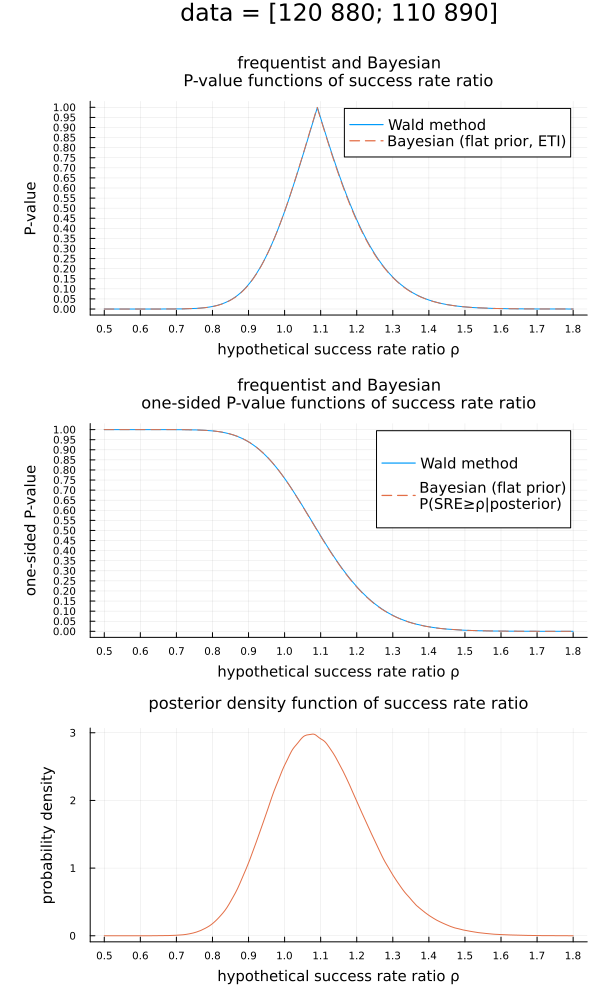

In [2]:
a, b, c, d = 120, 1000-120, 110, 1000-110

@printf("95%% confidence interval of success rate ratio = [%.3f, %.3f]\n",
    confint_rr_wald(a, b, c, d)...)
@printf("95%% credible   interval of success rate ratio = [%.3f, %.3f]\n",
    posterior_credint_function_rr(a, b, c, d)()...)
println()

f(ρ) = pvalue_rr_wald(a, b, c, d; ρ)
g = posterior_pvalue_function_rr(a, b, c, d)

P = plot(f, 0.5, 1.8; label="Wald method")
plot!(g, 0.5, 1.8; label="Bayesian (flat prior, ETI)", c=2, ls=:dash)
plot!(xtick=0.1:0.1:3, ytick=0:0.05:1)
plot!(xguide="hypothetical success rate ratio ρ",
    yguide="P-value", guidefontsize=10)
title!("frequentist and Bayesian\nP-value functions of success rate ratio",
    titlefontsize=11)

h = posterior_pdf_rr(a, b, c, d)
Q = plot(h, 0.5, 1.8; label="", c=2)
plot!(xtick=0.1:0.1:3)
plot!(xguide="hypothetical success rate ratio ρ",
    yguide="probability density", guidefontsize=10)
title!("posterior density function of success rate ratio",
    titlefontsize=11)

F(ρ) = pvalue_rr_wald_onesided(a, b, c, d; ρ)
G = posterior_onesided_pvalue_function_rr(a, b, c, d)

R = plot(F, 0.5, 1.8; label="Wald method")
plot!(G, 0.5, 1.8; label="Bayesian (flat prior)\nP(SRE≥ρ|posterior)", c=2, ls=:dash)
plot!(xtick=0.1:0.1:3, ytick=0:0.05:1)
plot!(xguide="hypothetical success rate ratio ρ",
    yguide="one-sided P-value", guidefontsize=10)
title!("frequentist and Bayesian\none-sided P-value functions of success rate ratio",
    titlefontsize=11)

plot(P, R, Q; size=(600, 1000), layout=(3, 1))
plot!(leftmargin=10Plots.mm, tickfontsize=7, legendfontsize=10)
plot!(plot_title="data = [$a $b; $c $d]")

See also https://x.com/search?q=Greenland%20McElreath%20from%3Agenkuroki&src=typed_query&f=live